In [3]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
import re
pd.options.mode.copy_on_write = True

In [45]:
class gitinfo:
    def __init__(self):
        while True:
            res = requests.get('https://github.com/luciusgibbons/FIRE-Project/tree/main/LSTM/CSVs%20with%20indexes') #pulls data from github folder link
            soup = bs(res.text, 'lxml')   
            file = soup.find_all(title=re.compile(r"\.csv$")) #list of all items with .csv THERE WILL BE DUPLICATES
            if len(file) != 0: #sometimes the api fails and file is empty, just keeps going until it is populated
            
                output = set() #set to prevent duplicates 
            
                for i in file:
                    x = i.extract().get_text() #turns it into a text string
                    output.add(x) 
                    
                output = list(output) #back to list for indexing capabilities
                self.csv_list = output
                self.txt_list = [x.replace('.csv', '.txt') for x in output]
                break
    
def Standardize_Columns(oldframe):
    all = ['Temperature', 'Pressure', 'Humidity', '1.0 std', '2.5 std', '10 std', '1.0 atm', '2.5 atm', '10 atm', 'MQ7', 'Date', 'Time']
    selected = ['Temperature', 'Pressure', 'Humidity', '1.0 std', '2.5 std', '10 std']
    #selected = ['1.0 std', '2.5 std', '10 std']
    newframe = pd.DataFrame()
    
    for column in selected:
        newframe[column] = oldframe.loc[:, oldframe.columns[all.index(column)]]

    return newframe


def Add_Fire_Column(dataframe, textfile):
    dataframe['Fire'] = 0 #creates an empty column in the specified dataframe titled 'Fire'
    url = 'https://github.com/luciusgibbons/FIRE-Project/blob/main/LSTM/CSVs%20with%20indexes/'+textfile+'?raw=true' #creates url from name of textfile
    values = [int(i) for i in list(pd.read_csv(url))] #generates a dataframe from the file, converts it to a list, converts each item in list to int()
        
    if len(values) != 1 or values[0] !=0: #if len(values) == 1 AND values[0] == 0, there were no instances of fire
        for i in range(0, len(values), 2): #iterate through the length of the list by two
            intervals = range(values[i], values[i+1]) #creates a range from i to i+1
            dataframe.loc[intervals, 'Fire'] = 1 #in each range the value in 'Fire' is a 1 and not a 0

def Get_DateTime_Column(newframe, oldframe): #pulls date and time from oldframe and adds DateTime to newframe
    date = oldframe.columns[list(oldframe.columns.str.lower()).index('date')] #pulls name of date column in oldframe case-insensitive without changing name
    time = oldframe.columns[list(oldframe.columns.str.lower()).index('time')]
    oldframe[date] = oldframe[date].apply(lambda x: pd.to_datetime(x).strftime('%m/%d/%Y')) #eg 07/17/24 ==> 07/17/2024, but 07/17/2024 still works
    newframe['DateTime'] = pd.to_datetime(oldframe[[date, time]].agg(' '.join, axis=1), format='%m/%d/%Y %H:%M:%S') #convert to Pandas DateTime object

def Purge_Init_Zeros(dataframe):
    while 0 in dataframe.loc[0, dataframe.columns[0:6]].values: #while theres a 0 in the first row in any of the first 6 columns:
        dataframe.drop(index=0, inplace=True) #drops that row
        dataframe.reset_index(drop=True, inplace=True) #fixes index

def Linear_Scale(column): #normal absolute max normalization
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
def Z_norm(column): #see z-score normalization, better for outlier detection
    df[column] = (df[column] - df[column].mean()) / df[column].std()


In [11]:
a = gitinfo()

csvs = a.csv_list
txts = a.txt_list

In [29]:

df_list = [pd.read_csv('https://github.com/luciusgibbons/FIRE-Project/blob/main/LSTM/CSVs%20with%20indexes/'+csv+'?raw=true') for csv in csvs] #creates a list of dataframes from list of csvs
new_df_list = [Standardize_Columns(i) for i in df_list] #creates a new list of dataframes, useful for preserving old data

for i in range(len(new_df_list)): #go through each df by index and:
    Add_Fire_Column(new_df_list[i], txts[i]) #add fire column from associated txt file
    Get_DateTime_Column(new_df_list[i], df_list[i]) #DateTime object column, pulls from df_list
    Purge_Init_Zeros(new_df_list[i]) #first couple of columns tend to have 0s where they shouldn't, purge them
    new_df_list[i].drop_duplicates(subset=new_df_list[i].columns[0:6],ignore_index=True, inplace=True) #drop duplicates

df = pd.concat(new_df_list, ignore_index=True) #concatenate the list into a single dataframe for more processing

In [31]:
df

,Temperature,Pressure,Humidity,1.0 std,2.5 std,10 std,Fire,DateTime
0,2120,100407,-29721,14,19,19,0,2024-07-19 09:51:41
1,2121,100407,-29744,14,19,19,0,2024-07-19 09:51:42
2,2123,100407,-29750,14,19,19,0,2024-07-19 09:51:43
3,2123,100406,-29704,12,17,32,0,2024-07-19 09:51:44
4,2123,100406,-29670,12,17,32,0,2024-07-19 09:51:45
...,...,...,...,...,...,...,...,...
21730,2324,100328,28541,31,90,126,0,2024-07-19 10:21:11
21731,2324,100327,28762,31,90,126,0,2024-07-19 10:21:12
21732,2322,100327,28819,31,90,126,0,2024-07-19 10:21:13
21733,2322,100327,28807,41,79,87,0,2024-07-19 10:21:14


Text(0, 0.5, 'Concentration of 10µm diameter particles in μg/m^3')

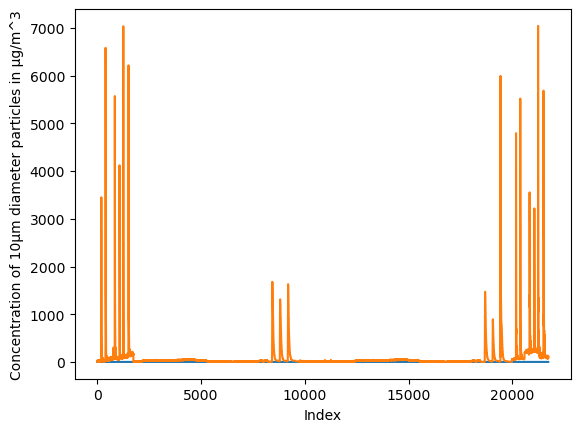

In [43]:
plt.plot(df.index[:], df['Fire'], df['10 std'])

plt.xlabel('Index')
plt.ylabel('Concentration of 10µm diameter particles in μg/m^3')

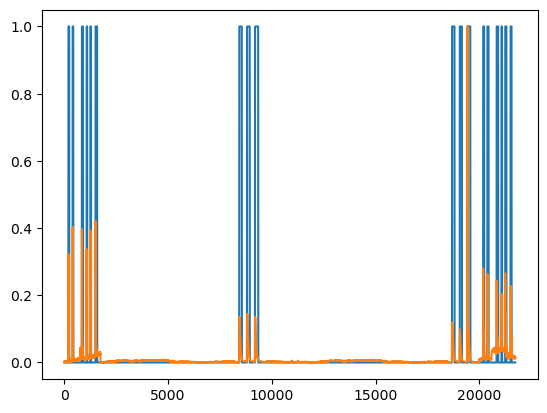

In [47]:
df['Temperature'] = (df['Temperature'] / 500) + 24 #converts to deg C
df['Humidity'] = df['Humidity'] / 512

df = df.assign(Humidity=df['Humidity'].abs()) #turns humidity positive since its just negative sometimes

df.drop(df[df['Humidity'] == 0].index, inplace=True) #drops anytime humidity is 0
df.drop(df[df['Pressure'] == 0].index, inplace=True) #drops anytime pressure is 0


for i in range(6):
    df[str(df.columns[i])] = df[str(df.columns[i])].astype(float) #iterates through the first 6 lines and turns it into a float

r'''
[df[str(df.columns[i])].astype(float) for i in range(6)]
def Floating_Point(column):
    df[column] = df[column].astype(float)
dataframe[str(dataframe.columns[i])].astype(float) for i in range(6)
'''

Z_norm("1.0 std")
Z_norm("2.5 std")
Z_norm("10 std")

for i in range(6):
    column = str(df.columns[i])
    Linear_Scale(column)




path=r'C:\Users\luciu\Desktop\Processed CSVs'
#df.to_csv(os.path.join(path,r'Preprocessed_node_2_07_19_24.csv'), index=False)


#plt.plot(df.index[:], df['Temperature'][:])
plt.plot(df.index[:], df['Fire'], df['2.5 std'])

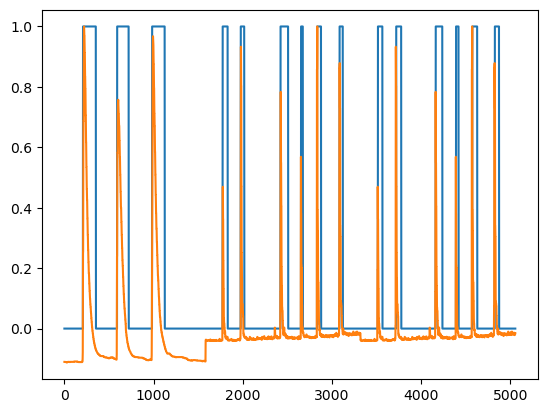

In [19]:
import pandas as pd
import glob
import os

os.chdir(r"C:\Users\luciu\Desktop\Processed CSVs")

extension = 'csv' #grabs only csv files in that directory
all_filenames = [i for i in glob.glob('*.{}'.format(extension))] #list of all file names only csvs


cdf = pd.concat([pd.read_csv(f) for f in all_filenames ], ignore_index=True) #combined dataframe

pathout=r'C:\Users\luciu\Desktop'
cdf.to_csv(os.path.join(pathout,r'combined_processed1.csv'), index=False)

plt.plot(cdf.index[:], cdf['Fire'], cdf['10 std'])